In [39]:
import random
import numpy as np
import networkx as nx 
from dijkstar import Graph, find_path

In [40]:
def generate_instance_matrix(nb_vertex, min_weight, max_weight, density):
  graph = np.ones((nb_vertex, nb_vertex)) * np.inf
  for i in range(nb_vertex - 1):
    for j in range(i+1, nb_vertex):
      if random.uniform(0, 1) < density:
        weight = random.randint(min_weight, max_weight)
        graph[i, j] = weight
        graph[j, i] = weight
  for i,line in enumerate(graph):
    index_zeros = np.where(line == np.inf)[0]
    index_zeros = np.delete(index_zeros, np.where(index_zeros == i))
    for j in range(len(index_zeros) - (nb_vertex - 3)):
      index = random.choice(index_zeros)
      index_zeros = np.delete(index_zeros, np.where(index_zeros == index))
      weight = random.randint(min_weight, max_weight)
      graph[i, index] = weight
      graph[index, i] = weight
  return graph

def convert_graph(graph):
  graph_dijkstra = Graph()
  for i in range(len(graph)):
    for j in range(len(graph)):
      graph_dijkstra.add_edge(i, j,graph[i][j])
  return graph_dijkstra

def get_distance_between_nodes(graph, i, j):
  if (graph[i][j] != np.inf):
    return graph[i][j], [i, j]
  else:
    if i != j:
      shortest_path = find_path(graph, i,j)
      return shortest_path.total_cost, shortest_path.nodes
    else:
      return 0, None

def get_complete_graph(graph, node_list):
  all_paths = {}
  converted_graph = convert_graph(graph)
  complete_graph = np.zeros((len(node_list), len(node_list)))
  for i in node_list:
    voisins_array = np.delete(node_list, np.where(node_list == i))
    for j in voisins_array:
      distance, path = get_distance_between_nodes(converted_graph, i, j)
      converted_graph_i = np.where(node_list == i)[0][0]
      converted_graph_j = np.where(node_list == j)[0][0]
      complete_graph[converted_graph_i][converted_graph_j] = distance
      all_paths[(converted_graph_i, converted_graph_j)] = path
  return complete_graph, all_paths

def get_random_vertex(size, nb_vertex):
  random_vertex = []
  all_vertex = np.array(range(size))
  for _ in range(nb_vertex):
    value = random.choice(all_vertex)
    random_vertex.append(value)
    all_vertex = np.delete(all_vertex, np.where(all_vertex == value))
  return np.array(random_vertex)

def generate_interval():
  interval = random.choice(range(1,4))
  shift = random.choice(range(0, 11-interval))
  return(shift*60, (shift+interval)*60)

def generate_instance(nb_vertex_matrix, min_weight, max_weight, density, random_vertex):
  graph = generate_instance_matrix(nb_vertex_matrix, min_weight, max_weight, density)
  complete_graph, all_paths = get_complete_graph(graph, random_vertex)
  return graph, complete_graph, all_paths

def get_complete_path(path, all_paths):
  complete_path = []
  for i in range(len(path) - 1):
    complete_path.extend(all_paths[(path[i], path[i+1])][:-1])
    if i == len(path) - 2:
      complete_path.append(all_paths[(path[i], path[i+1])][-1])
  return complete_path

def is_path_in_interval(path, complete_graph, interval, vertex):
  weight = 0
  for i in range(np.where(np.array(path) == vertex)[0][0]):
    weight += complete_graph[path[i]][path[i+1]]
  if weight >= interval[0] and weight <= interval[1]:
    return True
  else:
    return False

def generate_neighbours(path, complete_graph, interval, vertex):
  neighbours = []
  for i in range(len(path)):
    for j in range(i + 1, len(path)-1):
      new_neighbour = path.copy()

      new_neighbour[i] = path[j]
      new_neighbour[j] = path[i]
      
      if is_path_in_interval(new_neighbour, complete_graph, interval, vertex) and new_neighbour[0] == new_neighbour[-1]:
        neighbours.append(new_neighbour)
  return neighbours

def generate_random_path(nb_vertex, start_vertex):
  path = np.arange(nb_vertex)
  path = np.delete(path, np.where(path == start_vertex))
  np.random.shuffle(path)
  path = np.append(path, start_vertex)
  path = np.insert(path, 0, start_vertex)
  return path



In [41]:
import pickle
with open("data.pickle", "rb") as file:
  data = pickle.load(file)


graph = data["graph"]
complete_graph = data["complete_graph"]
all_paths = data["all_paths"]
vertices_list = data["vertices_list"]
start_vertex = data["start_vertex"]
start_vertex_index = data["start_vertex_index"]
interval_vertex = data["interval_vertex"]
interval_vertex_index = data["interval_vertex_index"]
interval = data["interval"]

path = generate_random_path(len(vertices_list), start_vertex_index)
print(path)


[1 3 2 0 1]


In [42]:
# generate the neighbours of a path

neighbours = generate_neighbours(path, complete_graph, interval, interval_vertex_index)
print(neighbours)


[array([1, 2, 3, 0, 1], dtype=int64), array([1, 0, 2, 3, 1], dtype=int64), array([1, 3, 0, 2, 1], dtype=int64)]


In [43]:
from pulp import *
import numpy as np


X=[]
P = []
X_dict = {}
True_tab = []



# variables du problème
for i in range(len(complete_graph)):
    for j in range(len(complete_graph)):
        X.append(LpVariable("X_" + str(i) + "_" + str(j), 0, 1, LpInteger))
        X_dict[("X_" + str(i) + "_" + str(j))] = LpVariable("X_" + str(i) + "_" + str(j), 0, 1, LpInteger)
        P.append(complete_graph[i][j])

# probleme
prob = LpProblem("plus court chemin", LpMinimize)

# objectif
# Somme de la multiplication des poids de chaque arc
prob += lpSum([P[i] * X[i] for i in range(len(P))])

# contraintes
# La somme d'un arc doit etre egale a 1
X_np = np.array(X)
X_np_reshape = X_np.reshape(len(complete_graph), len(complete_graph))

for i in range(len(X_np_reshape)):
    prob += lpSum(X_np_reshape[i]) == 1
    prob += X_np_reshape[i][i] == 0
    for j in range(len(X_np_reshape)):
        if i != j:
            prob += X_np_reshape[i][j] + X_np_reshape[j][i] <= 1
            """for a in range(len(X_np_reshape)):
                if i != a and j != a:
                    prob += X_np_reshape[i][a] + X_np_reshape[j][a] + X_np_reshape[a][i] + X_np_reshape[a][j] <= 2
"""

prob.solve()
print(LpStatus[prob.status])
print("Min=", value(prob.objective))

# variables resultat
for v in prob.variables():
    print("%s=%.2f"%(v.name,v.varValue), end=', ')


Optimal
Min= 95.0
X_0_0=0.00, X_0_1=1.00, X_0_2=0.00, X_0_3=0.00, X_1_0=0.00, X_1_1=0.00, X_1_2=1.00, X_1_3=0.00, X_2_0=1.00, X_2_1=0.00, X_2_2=0.00, X_2_3=0.00, X_3_0=0.00, X_3_1=0.00, X_3_2=1.00, X_3_3=0.00, 

In [44]:
nb_iterations=10000 #Dans la boucle while de la boucle principale
T0 = 3000 #Température de départ
Tmin = 1e-2 #Température minimale
tau = 1e4 #Pour la loi de refroidissement


In [45]:
def distance_tot(matrice,path_matrix):
    distance_tot = 0
    ind = 2
    points = [0,0]
    for i in range(len(path_matrix)):
        if i == 0:
            points = path_matrix[0:2]
            distance_tot += get_distance_between_nodes(matrice,points[0],points[1])[0]
        else:
            if (ind <= len(matrice)):
                points = path_matrix[ind-1:ind+1]
                distance_tot += get_distance_between_nodes(matrice,points[0],points[1])[0]
                ind += 1
    return distance_tot

print(distance_tot(complete_graph,path))


112.0


In [46]:
from ipywidgets import IntProgress 
from IPython.display import display

def recuit_simule_matrix(matrix,path):
    bar = IntProgress(min=0, max=nb_iterations, layout={"width" : "100%"})
    display(bar)
    i_tab = []
    T_Tab = []
    distance_tab = []

    distance = distance_tot(matrix,path)
    solution = np.copy(path)
    i = 0
    T=T0

    while T>Tmin and i<nb_iterations:
        i_tab.append(i)
        T_Tab.append(T)
        distance_tab.append(distance)
        i+=1

        #Loi de refroidissement
        T = T0 * np.exp(-i/tau)

        solution_voisine = neighbours[np.random.randint(0, len(neighbours))]
        
        while is_path_in_interval(solution_voisine, matrix, interval, 3) == False:
            solution_voisine = neighbours[np.random.randint(0, len(neighbours))]

        #Création de la nouvelle solution proche de la precedente
        

        #Comparaison des deux valeurs
        difference = distance_tot(matrix,solution) - distance_tot(matrix,solution_voisine)

        # Si la nouvelle solution est meilleure, on la prend
        if difference > 0:
            solution = solution_voisine
            distance = distance_tot(matrix,solution_voisine)
        
        # Sinon, on prend la solution actuelle
        else:
            if np.random.uniform() > np.exp(-difference/T): #on accepte la solution avec une certaine probabilité. 
                solution=solution_voisine
                distance=distance_tot(matrix,solution_voisine)
        
        bar.value += 1
    bar.close()
    return solution,distance,i_tab,T_Tab,distance_tab
    

solution, distance, i_tab, T_tab, distance_tab = recuit_simule_matrix(complete_graph,path)


# Make a multistart of recuit_simule_matrix
for _ in range (10):  
    path = generate_random_path(len(vertices_list), start_vertex_index)
    solution_courante, distance_courante, i_tab, T_tab, distance_tab = recuit_simule_matrix(complete_graph,path)
    if distance_courante < distance:
        solution = solution_courante
        distance = distance_courante
        i_tab = i_tab
        T_tab = T_tab
        distance_tab = distance_tab
print(solution,distance)


IntProgress(value=0, layout=Layout(width='100%'), max=10000)

IntProgress(value=0, layout=Layout(width='100%'), max=10000)

IntProgress(value=0, layout=Layout(width='100%'), max=10000)

IntProgress(value=0, layout=Layout(width='100%'), max=10000)

IntProgress(value=0, layout=Layout(width='100%'), max=10000)

IntProgress(value=0, layout=Layout(width='100%'), max=10000)

IntProgress(value=0, layout=Layout(width='100%'), max=10000)

IntProgress(value=0, layout=Layout(width='100%'), max=10000)

IntProgress(value=0, layout=Layout(width='100%'), max=10000)

IntProgress(value=0, layout=Layout(width='100%'), max=10000)

IntProgress(value=0, layout=Layout(width='100%'), max=10000)

[1 2 3 0 1] 104.0


Au bout de  10000 itérations, la meilleure solution avec le mélange simple est de visiter les villes dans cet ordre :
1 ->
2 ->
3 ->
0 ->
1 ->
La distance parcourue de la 1ere liste était de  120.0 km.
La distance parcourue au total est de  104.0 km.


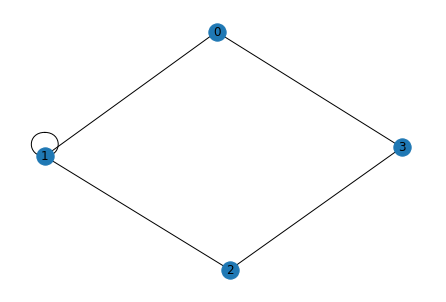

In [47]:
def afficher_villes(liste):
    for i in range(0,len(liste)):
        print(liste[i],"->")

print ("Au bout de ",nb_iterations,"itérations, la meilleure solution avec le mélange simple est de visiter les villes dans cet ordre :")
afficher_villes(solution)

print("La distance parcourue de la 1ere liste était de ", distance_tot(complete_graph,path), "km.")
print("La distance parcourue au total est de ", distance_tot(complete_graph,solution), "km.") 

tab_path_real = get_complete_path(solution, all_paths)

G = nx.Graph()
G.add_nodes_from(solution)
for i in range(len(solution)):
    G.add_edge(solution[i],solution[(i+1)%len(solution)])


nx.draw(G, with_labels=True)

10000
10000
10000


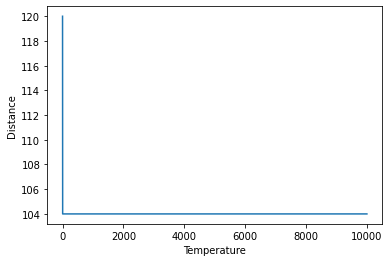

In [48]:
# explore temperature vs algorithm iteration for simulated annealing
from matplotlib import pyplot


print(len(i_tab))
print(len(T_tab))
print(len(distance_tab))

# plot T_tab vs distance_tab
pyplot.plot(distance_tab)


pyplot.xlabel('Temperature')
pyplot.ylabel('Distance')
pyplot.show()